%load_ext autoreload
%autoreload 2
https://blog.csdn.net/m0_46413065/article/details/129917287

In [78]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn

In [79]:
data_g2 = pd.read_csv("./Data/Taipei/h23-g1.csv",delimiter=';')
data_g3 = pd.read_csv("./Data/Kaohsiung/g3.csv",delimiter=';')
data_g4 = pd.read_csv("./Data/Kaohsiung/g4.csv",delimiter=';')
data = [data_g2]

features = ['date_time']
targets = ['EMove', 'NMove', 'HMove']
group_id_i = 2

for i in range(1):
    data[i]['date_time'] = pd.to_datetime(data[i]['date_time'])
    data[i]['date_time'] = data[i]['date_time'].astype(int) / (10 ** 11)
    data[i]['date_time'] = data[i]['date_time'].astype(int)
    data[i] = data[i][features+targets]
    #data[i]['group_id'] = group_id_i
    group_id_i += 1
    
data = pd.concat(data,ignore_index=True)
data['group_id'] = 0

In [80]:
data.head()

,date_time,EMove,NMove,HMove,group_id
0,16794870,0.0,0.0,0.0,0
1,16794876,0.1,0.5,1.0,0
2,16794882,0.8,1.0,0.9,0
3,16794888,1.6,1.7,3.1,0
4,16794894,3.0,3.1,5.8,0


In [81]:
data.tail()

,date_time,EMove,NMove,HMove,group_id
74028,17342592,-38.8,72.4,13.8,0
74029,17342598,-38.8,72.4,13.8,0
74030,17342604,-38.8,72.4,13.8,0
74031,17342610,-39.2,71.5,12.4,0
74032,17342616,-40.0,74.6,19.8,0


In [82]:
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import MultiNormalizer,TorchNormalizer

max_prediction_length = 7#*144
max_encoder_length = 7*144

training = TimeSeriesDataSet(
    data[:int(len(data)*0.8)],
    group_ids = ["group_id"],
    target = targets,
    time_idx = "date_time",
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    min_encoder_length=max_encoder_length//2,  # 似乎要自己設置(默認值好像太大?)
    min_prediction_length=1,  #同上
    time_varying_unknown_reals = targets,
    target_normalizer=MultiNormalizer([TorchNormalizer() for _ in targets]),
    allow_missing_timesteps=True
)

validation = TimeSeriesDataSet.from_dataset(training,data,predict=True,stop_randomization=True)

batch_size = 32

train_dataloader = training.to_dataloader(train=True,batch_size=batch_size,num_workers=4)
val_dataloader = validation.to_dataloader(train=False,batch_size=batch_size*10,num_workers=4)

In [83]:
# from pytorch_forecasting import Baseline

# actuals = torch.cat([y[0] for x, (y,weight) in iter(val_dataloader)])
# baseline_predictions = Baseline().predict(val_dataloader)
# # 假設你希望將 `baseline_predictions` 移動到相同的設備
# baseline_predictions = baseline_predictions.to(actuals.device)

# # 現在兩者在相同設備上，可以進行計算
# result = (actuals - baseline_predictions).abs().mean().item()

from pytorch_forecasting import Baseline

# 取得 `actuals`，支援多個 target
actuals = torch.cat([y if isinstance(y, torch.Tensor) else y[0] for x, (y, weight) in iter(val_dataloader)])

# 獲取 baseline 預測值
baseline_predictions = Baseline().predict(val_dataloader)

# 確保 `baseline_predictions` 是 tensor
if isinstance(baseline_predictions, list):
    baseline_predictions = torch.stack(baseline_predictions, dim=1)  # 確保維度對應

# 確保 baseline_predictions 在相同設備
baseline_predictions = baseline_predictions.to(actuals.device)

# 計算 MAE
result = (actuals - baseline_predictions).abs().mean(dim=[0, 2])  # 針對每個 target 計算 MAE
print("MAE for each target:", result.tolist())


/home/undergrad/miniconda3/envs/114/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/undergrad/miniconda3/envs/114/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 

MAE for each target: [0.5142871141433716, 111.71428680419922, 53.11428451538086]


In [84]:
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import TemporalFusionTransformer, QuantileLoss, MultiLoss

early_stop_callback = EarlyStopping(monitor="val_loss",min_delta=1e-4,patience=5,verbose=True,mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(
    max_epochs=15,
    accelerator = 'gpu',
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    accumulate_grad_batches=4,
    callbacks=[lr_logger,early_stop_callback],
    logger=logger
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=100,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=40,
    output_size=[1,1,1], #len(targets),
    loss=MultiLoss([QuantileLoss(quantiles=[0.5]),QuantileLoss(quantiles=[0.5]),QuantileLoss(quantiles=[0.5])]),
    log_interval=10,
    reduce_on_plateau_patience=4
)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MultiLoss                       | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 320    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 12.1 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 36.9 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0      | train
7  | static_co

Epoch 0: 100%|██████████| 1915/1915 [02:15<00:00, 14.18it/s, v_num=16, train_loss_step=2.47e+4, val_loss=2.6e+4, train_loss_epoch=7.24e+4]

Metric val_loss improved. New best score: 26016.258


Epoch 1: 100%|██████████| 1915/1915 [02:15<00:00, 14.14it/s, v_num=16, train_loss_step=2.06e+4, val_loss=6.46e+3, train_loss_epoch=3.88e+4]

Metric val_loss improved by 19560.072 >= min_delta = 0.0001. New best score: 6456.185


Epoch 6: 100%|██████████| 1915/1915 [02:24<00:00, 13.21it/s, v_num=16, train_loss_step=1.04e+4, val_loss=7.47e+3, train_loss_epoch=2.87e+4]

Monitored metric val_loss did not improve in the last 5 records. Best score: 6456.185. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 1915/1915 [02:25<00:00, 13.16it/s, v_num=16, train_loss_step=1.04e+4, val_loss=7.47e+3, train_loss_epoch=2.87e+4]


In [85]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

lightning_logs/lightning_logs/version_16/checkpoints/epoch=6-step=3353.ckpt


/home/undergrad/miniconda3/envs/114/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/undergrad/miniconda3/envs/114/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [86]:
for x, (y, weight) in iter(val_dataloader):
    print(f"Type of y: {type(y)}")
    print(f"Example of y: {y}")
    break  # Just checking one batch

Type of y: <class 'list'>
Example of y: [tensor([[-39.2000, -39.2000, -39.2000, -39.2000, -39.2000, -39.2000, -40.0000]]), tensor([[71.5000, 71.5000, 71.5000, 71.5000, 71.5000, 71.5000, 74.6000]]), tensor([[12.4000, 12.4000, 12.4000, 12.4000, 12.4000, 12.4000, 19.8000]])]


In [87]:

#actuals = torch.cat([y for x,y in iter(val_dataloader)]).cpu().numpy()
#actuals = torch.cat([torch.tensor(y) if isinstance(y, list) else y for x, (y, weight) in iter(val_dataloader)])
actuals = torch.cat([t for t in y], dim=0)

predictions = best_tft.predict(val_dataloader)
predictions = torch.stack(predictions)  # This assumes each element in predictions is a tensor of shape (num_samples, 1)
predictions = predictions.squeeze(1)  # Remove the dimension of size 1, leaving shape (3, 7)
print(f"actuals shape: {actuals.shape}")
print(f"predictions shape: {predictions.shape}")

from sklearn.metrics import mean_absolute_error, mean_squared_error 

#mae_T = mean_absolute_error(actuals, predictions)
#rmse_T = np.sqrt(mean_squared_error(actuals, predictions))

#print(mae_T,'\n',rmse_T)

# 对于每个目标，计算 MAE 和 RMSE
for target_idx in range(3):  # 假设 actuals 和 predictions 的形状是 (num_samples, num_targets)
    actual_target = actuals[target_idx , :].cpu().numpy()
    predicted_target = predictions[target_idx,:].cpu().numpy()  # Ensure predictions have the same shape
    print(actual_target,'\n',predicted_target)

    mae = mean_absolute_error(actual_target, predicted_target)
    rmse = np.sqrt(mean_squared_error(actual_target, predicted_target))

    print(f"Target {target_idx + 1} MAE: {mae:.4f}")
    print(f"Target {target_idx + 1} RMSE: {rmse:.4f}")

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


actuals shape: torch.Size([3, 7])
predictions shape: torch.Size([3, 7])
[-39.2 -39.2 -39.2 -39.2 -39.2 -39.2 -40. ] 
 [-848.2775  -871.5582  -853.2221  -844.51086 -848.1297  -856.3684
 -862.7485 ]
Target 1 MAE: 815.6593
Target 1 RMSE: 815.7058
[71.5 71.5 71.5 71.5 71.5 71.5 74.6] 
 [-2697.8594 -2609.9873 -2529.7795 -2467.4998 -2427.5815 -2403.1448
 -2391.8608]
Target 2 MAE: 2575.9019
Target 2 RMSE: 2578.0837
[12.4 12.4 12.4 12.4 12.4 12.4 19.8] 
 [-3959.131  -4116.686  -4149.1157 -4122.8945 -4079.5234 -4039.2449
 -4009.5615]
Target 3 MAE: 4081.4797
Target 3 RMSE: 4081.9585


In [88]:
actuals_E = actuals[:, 0].cpu().numpy()
predicted_E = predictions[:,0].cpu().numpy()

print(actuals_E ,'\n' , predicted_E)
print(predictions,"\n")
print(actuals)

[-39.2  71.5  12.4] 
 [ -848.2775 -2697.8594 -3959.131 ]
tensor([[ -848.2775,  -871.5582,  -853.2221,  -844.5109,  -848.1297,  -856.3684,
          -862.7485],
        [-2697.8594, -2609.9873, -2529.7795, -2467.4998, -2427.5815, -2403.1448,
         -2391.8608],
        [-3959.1311, -4116.6860, -4149.1157, -4122.8945, -4079.5234, -4039.2449,
         -4009.5615]], device='cuda:0') 

tensor([[-39.2000, -39.2000, -39.2000, -39.2000, -39.2000, -39.2000, -40.0000],
        [ 71.5000,  71.5000,  71.5000,  71.5000,  71.5000,  71.5000,  74.6000],
        [ 12.4000,  12.4000,  12.4000,  12.4000,  12.4000,  12.4000,  19.8000]])


[-39.2 -39.2 -39.2 -39.2 -39.2 -39.2 -40. ] 
 [-848.2775  -871.5582  -853.2221  -844.51086 -848.1297  -856.3684
 -862.7485 ]


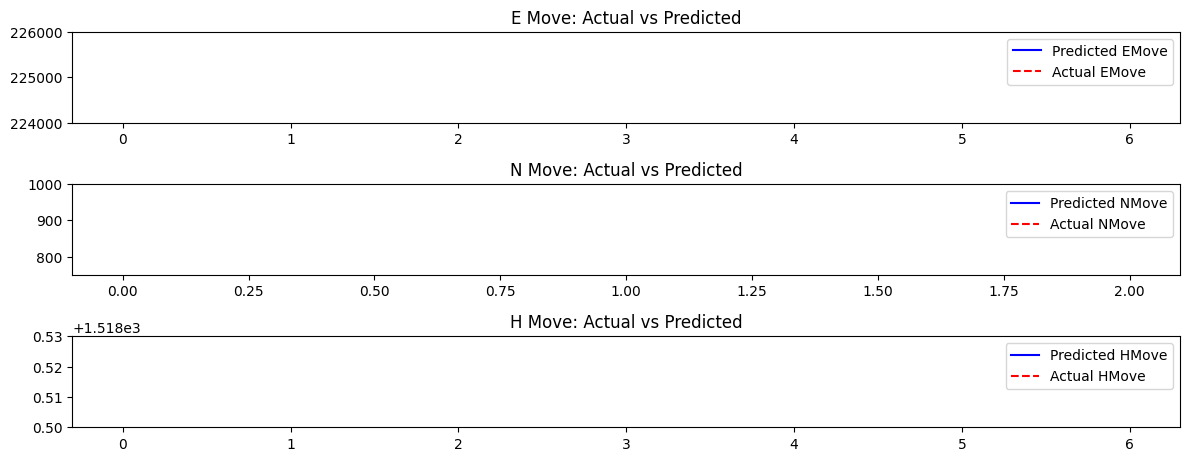

In [89]:
import matplotlib.pyplot as plt

# Find global min and max for y-axis across all movement components
y_min = 750  # You can adjust this to the actual min of your data
y_max = 1000  # You can adjust this to the actual max of your data

# Plot predictions vs actual values for each movement component
plt.figure(figsize=(12, 6))

# For EMove (target 0)
actuals_E = actuals[0,:].cpu().numpy()
predicted_E = predictions[0,:].cpu().numpy()
print(actuals_E,'\n',predicted_E)
plt.subplot(4, 1, 1)
plt.plot(predicted_E, label="Predicted EMove", color='blue')
plt.plot(actuals_E, label="Actual EMove", color='red', linestyle='dashed')
plt.title("E Move: Actual vs Predicted")
plt.ylim(224000,226000)  # Set same y-axis range
plt.legend()

# For NMove (target 1)
actuals_N = actuals[:, 1].cpu().numpy()
predicted_N = predictions[:, 1].cpu().numpy()
plt.subplot(4, 1, 2)
plt.plot(predicted_N, label="Predicted NMove", color='blue')
plt.plot(actuals_N, label="Actual NMove", color='red', linestyle='dashed')
plt.title("N Move: Actual vs Predicted")
plt.ylim(y_min, y_max)  # Set same y-axis range
plt.legend()

# For HMove (target 2)
actuals_H = actuals[2,:].cpu().numpy()
predicted_H = predictions[2,:].cpu().numpy()
plt.subplot(4, 1, 3)
plt.plot(predicted_H, label="Predicted HMove", color='blue')
plt.plot(actuals_H, label="Actual HMove", color='red', linestyle='dashed')
plt.title("H Move: Actual vs Predicted")
plt.ylim(1518.5,1518.53)  # Set same y-axis range
plt.legend()

plt.tight_layout()
plt.show()


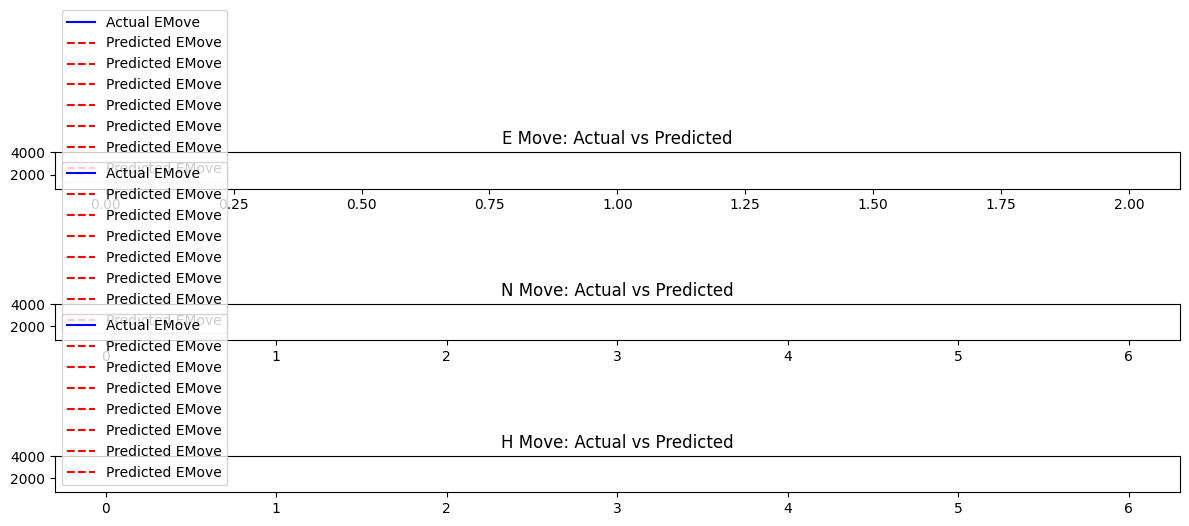

In [90]:
import matplotlib.pyplot as plt

# Find global min and max for y-axis across all movement components
y_min = 750#min(y_test_trues.min(), y_test_preds.min(), total_move_test_true.min(), total_move_test_pred.min())
y_max = 4000#max(y_test_trues.max(), y_test_preds.max(), total_move_test_true.max(), total_move_test_pred.max())

# Plot predictions vs actual values for  each movement component
plt.figure(figsize=(12, 6))

actuals[0, 0].cpu().numpy()
predicted_target = predictions[:,0].cpu().numpy()
plt.subplot(4, 1, 1)
plt.plot(predicted_target, label="Actual EMove", color='blue')
plt.plot(actuals, label="Predicted EMove", color='red', linestyle='dashed')
plt.title("E Move: Actual vs Predicted")
plt.ylim(y_min, y_max)  # Set same y-axis range
plt.legend()

actuals = torch.cat([y[1] for x,(y,weight) in iter(val_dataloader)])
predicted_target = predictions[1].cpu()
plt.subplot(4, 1, 2)
plt.plot(predicted_target, label="Actual EMove", color='blue')
plt.plot(actuals, label="Predicted EMove", color='red', linestyle='dashed')
plt.title("N Move: Actual vs Predicted")
plt.ylim(y_min, y_max)  # Set same y-axis range
plt.legend()

actuals = torch.cat([y[2] for x,(y,weight) in iter(val_dataloader)])
predicted_target = predictions[2].cpu()
plt.subplot(4, 1, 3)
plt.plot(predicted_target, label="Actual EMove", color='blue')
plt.plot(actuals, label="Predicted EMove", color='red', linestyle='dashed')
plt.title("H Move: Actual vs Predicted")
plt.ylim(y_min, y_max)  # Set same y-axis range
plt.legend()

plt.tight_layout()
plt.show()